# NLP Problem: Part of Speech Tagging for arabic language 
<u>Requirements</u>
1. Use of the datasets PADT, <u>**PUD**</u> or NYUAD
2. Implement 2 models : a DL model and a pre-DL model
3. I need good performance of a model at least better than 50% (random chance)

## Understand the nature of the dataset and problem

- Taken from [Universal Dependencies](https://universaldependencies.org/), I using the [Arabic PUD](https://universaldependencies.org/treebanks/ar_pud/index.html) (github[\*](https://github.com/UniversalDependencies/UD_Arabic-PUD))
- Uses articles from Wikipedia(W) and the news(N)
- Data is sequential (sequence of word) therefore use sequence-labeling model is prefered <br>

# DL model Chosen : Bi directional LSTM model (Bi-LSTM)
##### The Bi-LSTM is a sequential labeling classifier



## Load the libraries

In [1]:
import conllu
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import numpy as np

#encode the corpus to numbers
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import gensim


#build the lstm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import InputLayer

#performance evaluation
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix
#save model
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

## Read Data
- Interacting with CoNLL-U annotations in Python
- Importing conllu, a small library for **parsing CoNLL-U annotations** into various data structures native to Python.
- [Usefull tutorial](https://www.youtube.com/watch?v=lvJRFMvWtFI) with [github page](https://github.com/Applied-Language-Technology/notebooks/blob/main/part_iii/06_text_linguistics.ipynb) 

In [2]:
with open("..\\Universal Dependencies 2.10\\UD_Arabic-PUD\\ar_pud-ud-test.conllu", mode="r", encoding="utf-8") as data:

    #read the file contents and assign under 'annotations'
    annotations=data.read()

#check the type of the resulting object
print(type(annotations))
annotations[1:1000]

<class 'str'>


' newdoc id = n01001\n# sent_id = n01001011\n# text = كتبت كوري شولمان, المساعدة الخاصة لأوباما في تدوينة نشرتها يوم الإثنين: "فيما الكثير من عمليات الانتقال الرقمي غير مسبوقة في الولايات المتحدة, فإن الانتقال السلمي للسلطة سبق له أن حدث".\n# original_text = كتبت كوري شولمان, المساعدة الخاصة لأوباما في تدوينة نشرتها يوم الإثنين: "فيما الكثير من عمليات الانتقال الرقمي غير مسبوقة في الولايات المتحدة, فإن الانتقال السلمي للسلطة سبق له أن حدث".\n# text_en = “While much of the digital transition is unprecedented in the United States, the peaceful transition of power is not,” Obama special assistant Kori Schulman wrote in a blog post Monday.\n1\tكتبت\tkatab-u_1\tVERB\tVBC\tAspect=Perf|Gender=Fem|Number=Sing|Person=3|Tense=Past|Voice=Act\t0\troot\t_\t_\n2\tكوري\tkwry_0\tPROPN\tNNP\tAnimacy=Hum|Case=Nom|Gender=Fem|Number=Sing\t1\tnsubj\t_\t_\n3\tشولمان\t$wlmAn_0\tPROPN\tNNP\tAnimacy=Hum|Gender=Masc|Number=Sing\t2\tflat\t_\tSpaceAfter=No\n4\t,\t,_0\tPUNCT\t,\t_\t5\tpunct\t_\t_\n5\tالمساعدة\tmus

In [3]:
#parse the string of annotations to sentences
sentences = conllu.parse(annotations)

In [4]:
print(type(sentences))
sentences[0].metadata #metadata is simply a dictionary type
#meta data has 5 keys:newdoc id ,sent_id,text,original_text,text_en

<class 'conllu.models.SentenceList'>


{'newdoc id': 'n01001',
 'sent_id': 'n01001011',
 'text': 'كتبت كوري شولمان, المساعدة الخاصة لأوباما في تدوينة نشرتها يوم الإثنين: "فيما الكثير من عمليات الانتقال الرقمي غير مسبوقة في الولايات المتحدة, فإن الانتقال السلمي للسلطة سبق له أن حدث".',
 'original_text': 'كتبت كوري شولمان, المساعدة الخاصة لأوباما في تدوينة نشرتها يوم الإثنين: "فيما الكثير من عمليات الانتقال الرقمي غير مسبوقة في الولايات المتحدة, فإن الانتقال السلمي للسلطة سبق له أن حدث".',
 'text_en': '“While much of the digital transition is unprecedented in the United States, the peaceful transition of power is not,” Obama special assistant Kori Schulman wrote in a blog post Monday.'}

In [5]:
sentences[0][0]
#each sentence is a row , sentences[sentence_indx][:]
# to access each word within the sentence's pos, use sentences[sentence_indx][word_indx]['upos']

{'id': 1,
 'form': 'كتبت',
 'lemma': 'katab-u_1',
 'upos': 'VERB',
 'xpos': 'VBC',
 'feats': {'Aspect': 'Perf',
  'Gender': 'Fem',
  'Number': 'Sing',
  'Person': '3',
  'Tense': 'Past',
  'Voice': 'Act'},
 'head': 0,
 'deprel': 'root',
 'deps': None,
 'misc': None}

## Preprocessing Tasks for the data PUD:
1. Remove tanween and tashkeel
2. Remove sentences that contains non-arabic words (i.e. english)
Note : according to the sentences extracted from the dataset no preprocessing operations are applies such as lemmetization, nor arabic stopwords are removed

### Create corpus

In [6]:
def remove_tashkeel(w):
    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    w = re.sub(p_tashkeel,"", w)
    return w

In [7]:
#create a corpus : list of dictionaries, each dict is a sentence
corpus=[]
list_pos=[]
list_words=[]
pos=[]
list_sentences=[]
for sentence in sentences:
    word_dict={}
    sentence_txt=sentence.metadata['text']
    print(sentence_txt)# example of no preprocessing varification
    re_pattern = re.compile(r'[a-zA-Z]+')
    if re_pattern.search(sentence_txt)== None:
        list_sentences.append(sentence_txt)
        pos_bfr=[]
        for w_indx in range(len(sentence)):
            word_str=remove_tashkeel(sentence[w_indx]['form'])
            word_pos=sentence[w_indx]['upos']
            pos_bfr.append(word_pos)
            list_pos.append(word_pos)
            list_words.append(word_str)
            word_dict[w_indx]=[word_str,word_pos,sentence_txt,len(sentence_txt)]
        pos.append(pos_bfr)
        corpus.append(word_dict)

كتبت كوري شولمان, المساعدة الخاصة لأوباما في تدوينة نشرتها يوم الإثنين: "فيما الكثير من عمليات الانتقال الرقمي غير مسبوقة في الولايات المتحدة, فإن الانتقال السلمي للسلطة سبق له أن حدث".
بالنسبة إلى أولئك الذين يتابعون الانتقال الخاص بوسائل التواصل الاجتماعي في الكابيتول هيل, سيكون الأمر مختلفاً بعض الشيء.
لكن بعيداً عن كلامه السابق بشأن الحد من الهجرة, أعلن المرشح الجمهوري أنه كرئيس سيسمح "بأعدادٍ هائلة" من المهاجرين الشرعيين على أساس "نظام الجدارة".
قال للحشد الذي تجمع في أحد الملاعب الرياضية الخاصة بجامعة كارولينا الشمالية.
تمول النفقات الجديدة من خلال حساب كلينتون المصرفي الكبير.
إن ما تقوله وما تفعله... في الواقع, إنه أمرٌ لا يصدق.
الحد الأقصى المسموح به للشخص الواحد هو 5000 دولار.
في أوائل شهر تشرين الأول, استخدم الفريق الانتقالي ذات المكان للقاء جماعات الضغط التكنولوجية, بحضور ممثلين عن شركة "أوبر" وجمعية الفيلم الأمريكي وجمعية مستهلكي التكنولوجيا وغيرها.
كان من المقرر في الأصل أن يقام التجمع في نادي المتروبوليتان في واشنطن في شارع "إتش" الذي لا يبعد كثيراً.
لربما كان الزي الواجب

In [8]:
#report the info of the cleaned corpus
print("The corpus has {} sentences".format(len(corpus)))

The corpus has 998 sentences


In [9]:
#save the results in a dataframe 
df_w = pd.DataFrame (list_words, columns = ['w_name'])
df = pd.DataFrame (list_pos, columns = ['tag_name'])
df_w.to_csv("word_list_cleaned.csv", encoding="utf-8")
df.to_csv("tag_list.csv", encoding="utf-8")

[Text(0, 0, '5553'),
 Text(0, 0, '3564'),
 Text(0, 0, '2221'),
 Text(0, 0, '2021'),
 Text(0, 0, '1780'),
 Text(0, 0, '1722'),
 Text(0, 0, '1295'),
 Text(0, 0, '646'),
 Text(0, 0, '566'),
 Text(0, 0, '401'),
 Text(0, 0, '368'),
 Text(0, 0, '187'),
 Text(0, 0, '165'),
 Text(0, 0, '152'),
 Text(0, 0, '30'),
 Text(0, 0, '5')]

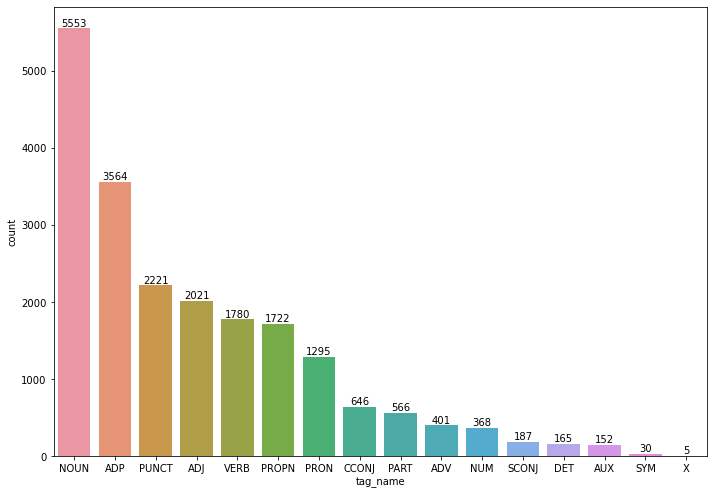

In [10]:
#plot the found tags with popularity of each in the corpus
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
ax = sns.countplot(x=df['tag_name'],
                   order=df['tag_name'].value_counts(ascending=False).index);

abs_values = df['tag_name'].value_counts(ascending=False).values

ax.bar_label(container=ax.containers[0], labels=abs_values)

### Preprocessing of Input Text data 
Inspired by [\*](https://medium.com/@WaadTSS/how-to-use-arabic-word2vec-word-embedding-with-lstm-af93858b2ce)

##### Preprocess the **input text data** <br>
Step1: convert from text to natural numbers<br>
Step2: unify the length of sentences by padding with direction= left<br>

In [11]:
def sentence_max_len(list_sentences):
    list_sentence_len=[]
    for sentence in list_sentences:
        list_sentence_len.append(len(sentence))
    return max(list_sentence_len)


#### encode sentences to numbers

In [12]:
tkn= Tokenizer()
#read the corpus
tkn.fit_on_texts(list_sentences)

vocab_size=len(tkn.word_index)+1 #the size is including the padding

#encoding the corpus
enc_corpus=tkn.texts_to_sequences(list_sentences)
enc_corpus
#structure of the encoded corpus
#list = [[sentence1], [sentence2],....., [word1, word2,word3,...]]

[[1995,
  406,
  1996,
  582,
  39,
  1997,
  1,
  1998,
  1999,
  49,
  2000,
  119,
  75,
  2,
  2001,
  234,
  972,
  26,
  2002,
  1,
  134,
  50,
  76,
  234,
  2003,
  2004,
  2005,
  301,
  3,
  181],
 [69,
  5,
  235,
  41,
  2006,
  234,
  155,
  2007,
  973,
  583,
  1,
  2008,
  974,
  236,
  53,
  975,
  91,
  584],
 [18,
  976,
  10,
  2009,
  302,
  77,
  407,
  2,
  2010,
  408,
  2011,
  409,
  35,
  2012,
  977,
  585,
  978,
  2,
  586,
  2013,
  4,
  979,
  182,
  2014],
 [55, 2015, 16, 2016, 1, 56, 2017, 2018, 39, 980, 587, 135],
 [2019, 981, 92, 2, 11, 2020, 237, 2021, 156],
 [100, 12, 2022, 588, 2023, 1, 589, 410, 982, 20, 2024],
 [407, 2025, 2026, 120, 2027, 2028, 37, 983, 136],
 [1,
  2029,
  411,
  57,
  30,
  412,
  2030,
  2031,
  65,
  984,
  2032,
  2033,
  590,
  2034,
  2035,
  2036,
  10,
  66,
  985,
  986,
  183,
  184,
  986,
  2037,
  413,
  303],
 [7,
  2,
  2038,
  1,
  987,
  3,
  988,
  2039,
  1,
  2040,
  2041,
  1,
  591,
  1,
  2042,
  2043,


In [13]:
print("The RNN input is type {} of sentences, \nEach sentence is a list of {} each representing words\nThe number of sentences is {} \n "
      .format(type(enc_corpus),type(enc_corpus[0][0]),len(enc_corpus)))

The RNN input is type <class 'list'> of sentences, 
Each sentence is a list of <class 'int'> each representing words
The number of sentences is 998 
 


#### Padding the shorter sentences

###### Compute maximum length of a sentence with the corpus

In [14]:
max_len=sentence_max_len(list_sentences)
max_len

257

##### Use pad_sequences of keras with padding direction to the left

In [15]:
pad_corpus=pad_sequences(enc_corpus, maxlen=max_len, padding='post')
pad_corpus.shape

(998, 257)

### Label Encode the output
Label encode the tags
#####  Preprocess the **output tags per sentence**<br>
Step1: create a dictionary of tags where label encoding is done alphebatically<br>
Step2: convert the tag text to tag number using dictionary<br>
Step3: unify the length of output array by padding with direction= left, and value (tag_name=X, tag_value=15)<br>
Step4: add 3rd dimension which represents the label encoding for each tag for each sentence<br>
Note: forth step is done to fit the last layer of time-distributed of the Bi-LSTM system

In [16]:
output=pos
flat_output = sum(output, [])
# create a dictionary to map target from txt to int label
pos_keyword=list(set(flat_output))
#sort it alphabatically first element is the first in alphabetical order
pos_keyword=sorted(pos_keyword)
max_len=sentence_max_len(list_sentences)
padding_value = pos_keyword.index("X")
print("the fixed output length is {}, where the padding value of x is {}"
      .format(max_len,padding_value))


arr_r=len(output)
arr_c=max_len
#fill-in (pad) all the label matrix
encoded_target = np.full((arr_r,arr_c),padding_value, dtype=int)
for sentence_ind in range(len(output)):
    sentence=output[sentence_ind]
    for pos_ind in range(len(sentence)):
        indiv_pos=output[sentence_ind][pos_ind]
        target_label=pos_keyword.index(indiv_pos)
        encoded_target[sentence_ind][pos_ind]=target_label


the fixed output length is 257, where the padding value of x is 15


In [17]:
print(output[0])
print(encoded_target[0][:41])

['VERB', 'PROPN', 'PROPN', 'PUNCT', 'NOUN', 'ADJ', 'ADP', 'PROPN', 'ADP', 'NOUN', 'VERB', 'PRON', 'ADV', 'PROPN', 'PUNCT', 'PUNCT', 'ADP', 'NOUN', 'ADP', 'NOUN', 'NOUN', 'ADJ', 'PART', 'ADJ', 'ADP', 'PROPN', 'ADJ', 'PUNCT', 'PART', 'PART', 'NOUN', 'ADJ', 'ADP', 'NOUN', 'VERB', 'ADP', 'PRON', 'ADP', 'VERB', 'PUNCT', 'PUNCT']
[14 10 10 11  6  0  1 10  1  6 14  9  2 10 11 11  1  6  1  6  6  0  8  0
  1 10  0 11  8  8  6  0  1  6 14  1  9  1 14 11 11]


In [18]:
encoded_target.shape

(998, 257)

#### One-Hot-Encode The Output

Format of the output (sentences, max_sentence_len, number_of_tags)

In [19]:
new_row=encoded_target.shape[0]
new_col=encoded_target.shape[1]
num_new_col=len(pos_keyword)
one_hot_encoded_col=np.zeros((new_row,new_col,num_new_col))
#cols 16, shape =(998, 257)

for sentence_ind in range(len(encoded_target)):
    sentence = encoded_target[sentence_ind]
    for word_ind in range(len(sentence)):
        
        #create the on-hot-encoding
        w_1hotenc = np.zeros((1,num_new_col))
        high_ind=sentence[word_ind-1]
        w_1hotenc[0][high_ind]=1
        
        #modify the target label matrix per word
        one_hot_encoded_col[sentence_ind][word_ind][:]=w_1hotenc
        
        

In [20]:
one_hot_encoded_col.shape

(998, 257, 16)

## Split the data into training and testing
- Ratio : 70%training-30%testing
- Split is done randomlyu with the ration 70-30 using numpy library

In [21]:
total_samples=pad_corpus.shape[0]
train_samples=round(total_samples* 0.7)

indices = np.random.permutation(total_samples)
training_idx, test_idx = indices[:train_samples], indices[train_samples:]
train_x, test_x = pad_corpus[training_idx,:], pad_corpus[test_idx,:]
train_y, test_y = one_hot_encoded_col[training_idx,:], one_hot_encoded_col[test_idx,:]

## Create the RNN Model

### Step1: Word Embedding
Word embeddings provide a <u>dense</u> representation of words and their relative meanings. <br>
**Embedding technique**  Word2Vec - skipgram [\*](https://github.com/bakrianoo/aravec) <br>

**keras - WordEmbedding Layer**
 [\*](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/),[\*](https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce),[\*](https://www.kaggle.com/code/rajmehra03/a-detailed-explanation-of-keras-embedding-layer)<br> takes as input:  
- input_dim ( dictionary_size )
- output_dim (number of sentences)
- input_length (max_wordcountNsentence)



General Notes: 
- here in embedding layer we have extracted the embedding for both the input and the output because the testing should have a pretrained word representation, it shall not be guessed, the case of out-of-vocab is when the word embedding pretrained model does not contain the word embedding for the word
- we have reduced the matrix to only include training and test, to speedup the performance, otherwise could just supply the full word embedding matrix

In [22]:
embedding_model = gensim.models.Word2Vec.load('full_uni_sg_300_twitter.mdl')


MemoryError: Unable to allocate 1.41 GiB for an array with shape (377926800,) and data type float32

In [ ]:
#list of words in the dictionary
#embedding_model.wv.index_to_key

In [ ]:
embeddings = {}
for word,vector in zip(embedding_model.wv.index_to_key,embedding_model.wv):
    coefs =[]
    coefs.append(vector)
    embeddings[word] = coefs
embeddings_weights = np.zeros((vocab_size, 300))
for word, i in tkn.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embeddings_weights[i] = embedding_vector[0]

### Create the model

In [130]:
def create_model():
    # define the model
    #output_dim=pad_corpus.shape[0]
    max_len=pad_corpus.shape[1]
    number_label_classes=len(pos_keyword)

    model = Sequential()
    model.add(Embedding(input_dim = vocab_size,output_dim=300,input_length = max_len,weights =[embeddings_weights],trainable=False))
    model.add(Bidirectional(LSTM(50, return_sequences=True)))
    model.add(Bidirectional(LSTM(50, return_sequences=True)))
    model.add(Bidirectional(LSTM(50, return_sequences=True)))
    model.add(Bidirectional(LSTM(50, return_sequences=True)))

    model.add(TimeDistributed(Dense(number_label_classes, activation='softmax')))

    #compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [131]:
# define the model
#output_dim=pad_corpus.shape[0]
max_len=pad_corpus.shape[1]
number_label_classes=len(pos_keyword)



model = Sequential()
model.add(Embedding(input_dim = vocab_size,output_dim=300,input_length = max_len,weights =[embeddings_weights],trainable=False))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Bidirectional(LSTM(50, return_sequences=True)))

model.add(TimeDistributed(Dense(number_label_classes, activation='softmax')))

#compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#summarize the model
model.summary()
#998 is the number of sentences, 257 is the embedding dimensions which is the maximum length
#1000 is 2 lstm of size 500 each in an opposite direction

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 257, 300)          2280900   
                                                                 
 bidirectional_4 (Bidirectio  (None, 257, 100)         140400    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 257, 100)         60400     
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 257, 100)         60400     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 257, 100)         60400     
 nal)                                                 

### Train the model

In [145]:
# fit the model
history=model.fit(train_x, train_y, validation_split=0.1,epochs=50, verbose=1)



Epoch 1/50
20/20 [==============================] - 97s 5s/step - loss: 0.1400 - accuracy: 0.9517 - val_loss: 0.1377 - val_accuracy: 0.9520
Epoch 2/50
20/20 [==============================] - 55s 3s/step - loss: 0.1391 - accuracy: 0.9520 - val_loss: 0.1363 - val_accuracy: 0.9520
Epoch 3/50
20/20 [==============================] - 53s 3s/step - loss: 0.1390 - accuracy: 0.9518 - val_loss: 0.1388 - val_accuracy: 0.9508
Epoch 4/50
20/20 [==============================] - 52s 3s/step - loss: 0.1405 - accuracy: 0.9512 - val_loss: 0.1401 - val_accuracy: 0.9506
Epoch 5/50
20/20 [==============================] - 47s 2s/step - loss: 0.1413 - accuracy: 0.9506 - val_loss: 0.1403 - val_accuracy: 0.9510
Epoch 6/50
20/20 [==============================] - 44s 2s/step - loss: 0.1394 - accuracy: 0.9514 - val_loss: 0.1395 - val_accuracy: 0.9503
Epoch 7/50
20/20 [==============================] - 46s 2s/step - loss: 0.1358 - accuracy: 0.9525 - val_loss: 0.1365 - val_accuracy: 0.9515
Epoch 8/50
20/20 [==

### Save & Load the trained model

In [146]:
model.save_weights("bilstm_model_aravec.h5")

In [147]:
loaded_model = create_model()
# Restore the weights
loaded_model.load_weights("bilstm_model_aravec.h5")

## Performance Evaluation
1. accuracy, recall, precision, and f1 measure,
2. confusion matrix
3. learning curve

In [154]:
loss,accuracy =model.evaluate(test_x, test_y)

10/10 [==============================] - 14s 1s/step - loss: 0.1510 - accuracy: 0.9547


### Post-Processing
Step1: round the predicted values to int (bcuz it is in the 1-hot-encoding format)<br>
Step2: convert from 1-hot-encoding format to label encoding<br>
Step3: convert from label encoding format to tag names<br>

In [149]:
#Step1: round the predicted values to int (bcuz it is in the 1-hot-encoding format)
predict_y=model.predict(test_x)
predict_y=np.rint(predict_y)
predict_y=predict_y.astype(int)

10/10 [==============================] - 8s 745ms/step


In [150]:
#Step2: convert from 1-hot-encoding format to label encoding
#pos_keyword is list of tags as words
def reverse_1hotenc(onehotenc,pos_keyword): 
    decoded=np.zeros((onehotenc.shape[0],onehotenc.shape[1]))
    for sentence_ind in range(len(onehotenc)):
        sentence = onehotenc[sentence_ind]
        for word_ind in range(len(sentence)):
            onehotenc_label= onehotenc[sentence_ind][word_ind]
            if np.where(onehotenc_label==1)[0].size > 0:
                decoded[sentence_ind][word_ind]=np.where(onehotenc_label==1)[0][0]
    return decoded
test_y=reverse_1hotenc(test_y,pos_keyword)
predict_y=reverse_1hotenc(predict_y,pos_keyword)

#### Confusion Matrix

array([15., 14., 10., 10.,  0., 14.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
       11., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15

#### Learning Curve

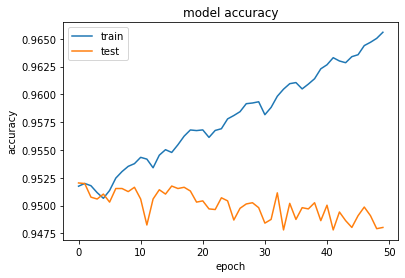

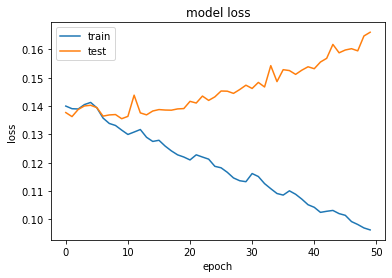

In [148]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()